In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import h5py

/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import os
import sys
import re
import string
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, confusion_matrix
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (Dense, Input, Flatten, MaxPooling1D, Conv1D, Reshape, concatenate,
                          Embedding, BatchNormalization, Activation, Dropout, GRU, Bidirectional)
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from AttentionWithContext import AttentionWithContext
from Attention import Attention

Using TensorFlow backend.


In [5]:
from gensim.models import KeyedVectors

In [6]:
data = pd.read_csv('../data/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
lens = data.comment_text.apply(lambda x: len(x.split()))

In [8]:
lens.describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

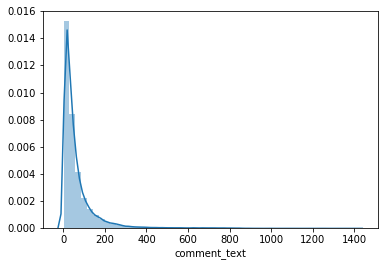

In [9]:
sns.distplot(lens)

In [10]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
comments = data['comment_text'].fillna('UNK').values
y = data[classes].values

train_comments, val_comments, y_train, y_val = train_test_split(comments, y, test_size=0.1)

In [11]:
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 400

In [12]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(train_comments)

In [13]:
train_sequences = tokenizer.texts_to_sequences(train_comments)
val_sequences   = tokenizer.texts_to_sequences(val_comments)
X_train         = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
X_val           = pad_sequences(val_sequences, maxlen = MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 197087 unique tokens.


In [14]:
! ls ../embeddings

glove.42B.300d.txt  glove.840B.300d.txt  wiki-news-300d-1M.vec
glove.42B.300d.zip  glove.840B.300d.zip  wiki-news-300d-1M.vec.zip


In [15]:
embeddings_index = {}
f = open('../embeddings/glove.42B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print("error reading word", word)
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [16]:
print('Preparing embedding matrix')
nb_words = min(MAX_NB_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 77088


In [32]:
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

x = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(comment_input)

x = Conv1D(32, kernel_size=3, padding='same',activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)

x = Conv1D(64 ,kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)

#x = Bidirectional(GRU(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)

predictions = Dense(6, activation='sigmoid')(x)

model = Model(comment_input, predictions)

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 300)          59126400  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 400, 32)           28832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 133, 32)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 133, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 133, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 44, 64)            0         
__________

In [35]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_ckpt = ModelCheckpoint(filepath='../models/conv1d_flatten.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2)
auc_monitor = RocAucEvaluation(interval=1, validation_data=(X_val, y_val))
callbacks = [model_ckpt, reduce_lr, early_stopping, model_ckpt, auc_monitor]

In [37]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512, epochs=20, callbacks=callbacks) 

Train on 143613 samples, validate on 15958 samples
Epoch 1/20
143613/143613 [==============================] - 55s 382us/step - loss: 0.2592 - acc: 0.9183 - val_loss: 0.0872 - val_acc: 0.9740

 ROC-AUC - epoch: 1 - score: 0.911845 

Epoch 2/20
143613/143613 [==============================] - 53s 368us/step - loss: 0.0868 - acc: 0.9733 - val_loss: 0.0830 - val_acc: 0.9738

 ROC-AUC - epoch: 2 - score: 0.921422 

Epoch 3/20
143613/143613 [==============================] - 53s 367us/step - loss: 0.0780 - acc: 0.9747 - val_loss: 0.0828 - val_acc: 0.9737

 ROC-AUC - epoch: 3 - score: 0.922290 

Epoch 4/20
143613/143613 [==============================] - 53s 367us/step - loss: 0.0719 - acc: 0.9762 - val_loss: 0.0827 - val_acc: 0.9735

 ROC-AUC - epoch: 4 - score: 0.920006 

Epoch 5/20
143613/143613 [==============================] - 53s 367us/step - loss: 0.0670 - acc: 0.9776 - val_loss: 0.0873 - val_acc: 0.9734

 ROC-AUC - epoch: 5 - score: 0.918849 

Epoch 6/20
143613/143613 [=============